<a href="https://colab.research.google.com/github/DrAlexSanz/nlpv2-course/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from wordcloud import WordCloud

In [24]:
# Get the data

!wget https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2022-08-05 09:47:59--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv.2’

AirlineTweets.csv.2 100%[===================>]   3.26M  --.-KB/s    in 0.05s   

2022-08-05 09:47:59 (63.7 MB/s) - ‘AirlineTweets.csv.2’ saved [3421431/3421431]



In [25]:
df_ = pd.read_csv("AirlineTweets.csv")

In [26]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [27]:
df = df_[["airline_sentiment", "text"]].copy() # I can probably improve the model using hte sentiment confidence column
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


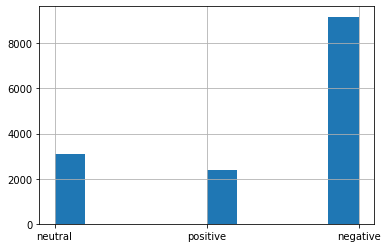

In [28]:
# See if it's 50-50

df["airline_sentiment"].hist() # There are a lot of negative examples. What a surprise! Being twitter data...

In [29]:
# Create numeric labels. Some libraries don't need this step
target_map = {"positive": 1, "negative": 0, "neutral": 2} # Mapping is arbitrary

df["target"] = df["airline_sentiment"].map(target_map)

In [30]:
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [31]:
# Split data

df_train, df_test = train_test_split(df,test_size = 0.2)
df_train.head()

,airline_sentiment,text,target
14210,negative,"@AmericanAir plane breaks, unloads the passeng...",0
2079,negative,@united been on hold for almost two hours tryi...,0
4788,positive,@SouthwestAir show me some love and a companio...,1
379,positive,@VirginAmerica Just bought tix for ATX - Dalla...,1
7297,negative,@JetBlue had a potentially stressful situation...,0


In [32]:
# Create training matrix

featurizer = TfidfVectorizer(max_features = 2000) # Limit the vocab size
x_train = featurizer.fit_transform(df_train["text"])
x_test = featurizer.transform(df_test["text"])
y_train = df_train["target"]
y_test = df_test["target"]
x_train


<11712x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 168483 stored elements in Compressed Sparse Row format>

In [34]:
model = LogisticRegression(max_iter = 500)
model_CNB = ComplementNB() # This one is in theory good for imbalanced classes
model_RF = RandomForestClassifier(n_estimators = 200, class_weight = "balanced")

model.fit(x_train, y_train)
print("Train accuracy = ", model.score(x_train, y_train))
print("Test accuracy = ", model.score(x_test, y_test))

model_CNB.fit(x_train, y_train)
print("Train_CNB accuracy = ", model_CNB.score(x_train, y_train))
print("Test_CNB accuracy = ", model_CNB.score(x_test, y_test))

model_RF.fit(x_train, y_train)
print("Train_RF accuracy = ", model_RF.score(x_train, y_train))
print("Test_RF accuracy = ", model_RF.score(x_test, y_test))

Train accuracy =  0.8553620218579235
Test accuracy =  0.7978142076502732
Train_CNB accuracy =  0.8214651639344263
Test_CNB accuracy =  0.7817622950819673
Train_CNB accuracy =  0.9957308743169399
Test_CNB accuracy =  0.7599043715846995


Keep in mind, this is accuracy and it's imbalanced. Look at confusion matrix

In [40]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
print("Train f1 score = ", f1_score(y_train, pred_train, average = "micro")) # Just a few
print("Test f1 score", f1_score(y_test, pred_test, average = "micro"))

pred_train_CNB = model_CNB.predict(x_train)
pred_test_CNB = model_CNB.predict(x_test)
print("Train_CNB f1 score = ", f1_score(y_train, pred_train_CNB, average = "weighted"))
print("Test_CNB f1 score", f1_score(y_test, pred_test_CNB, average = "weighted"))

pred_train_RF = model_RF.predict(x_train)
pred_test_RF = model_RF.predict(x_test)
print("Train_RF f1 score = ", f1_score(y_train, pred_train_RF, average = "macro"))
print("Test_RF f1 score", f1_score(y_test, pred_test_RF, average = "macro"))

Train f1 score =  0.8553620218579235
Test f1 score 0.7978142076502732
Train_CNB f1 score =  0.8225210652779678
Test_CNB f1 score 0.7817687758606365
Train_RF f1 score =  0.9934630778278087
Test_RF f1 score 0.6629487467138699


In [44]:
prob_train = model.predict_proba(x_train)#[:, 1] # We don't want to take only the first column, it's a multiclass classification
prob_test = model.predict_proba(x_test)#[:, 1]

print("Train AUC = ", roc_auc_score(y_train, prob_train, multi_class = "ovo")) # Can use OVR. I'm not going to look into it now.
print("Test AUC = ", roc_auc_score(y_test, prob_test, multi_class = "ovo"))

prob_train_CNB = model_CNB.predict_proba(x_train)#[:, 1]
prob_test_CNB = model_CNB.predict_proba(x_test)#[:, 1]

print("Train AUC = ", roc_auc_score(y_train, prob_train_CNB, multi_class = "ovo"))
print("Test AUC = ", roc_auc_score(y_test, prob_test_CNB, multi_class = "ovo"))

prob_train_RF = model_RF.predict_proba(x_train)#[:, 1]
prob_test_RF = model_RF.predict_proba(x_test)#[:, 1]

print("Train AUC_RF = ", roc_auc_score(y_train, prob_train_RF, multi_class = "ovo"))
print("Test AUC_RF = ", roc_auc_score(y_test, prob_test_RF, multi_class = "ovo"))

Train AUC =  0.950387713812843
Test AUC =  0.9094792201645315
Train AUC =  0.9261636284742666
Test AUC =  0.8962245664798373
Train AUC_RF =  0.9989756349782432
Test AUC_RF =  0.8843698911555252


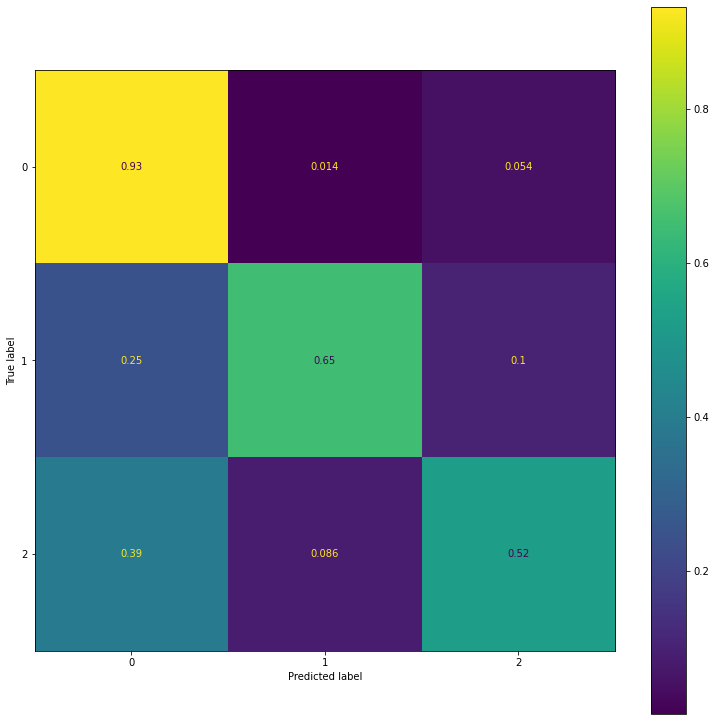

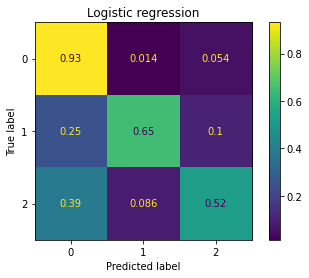

In [46]:
fig, ax = plt.subplots(figsize = (13, 13))
cm = ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, normalize = "true") # %s instead of numbers
plt.title("Logistic regression")
cm.plot(ax = ax)

# See how the biggest problem is in class predicted 0 when it should be 2 adn predicted 0 when it should be 1

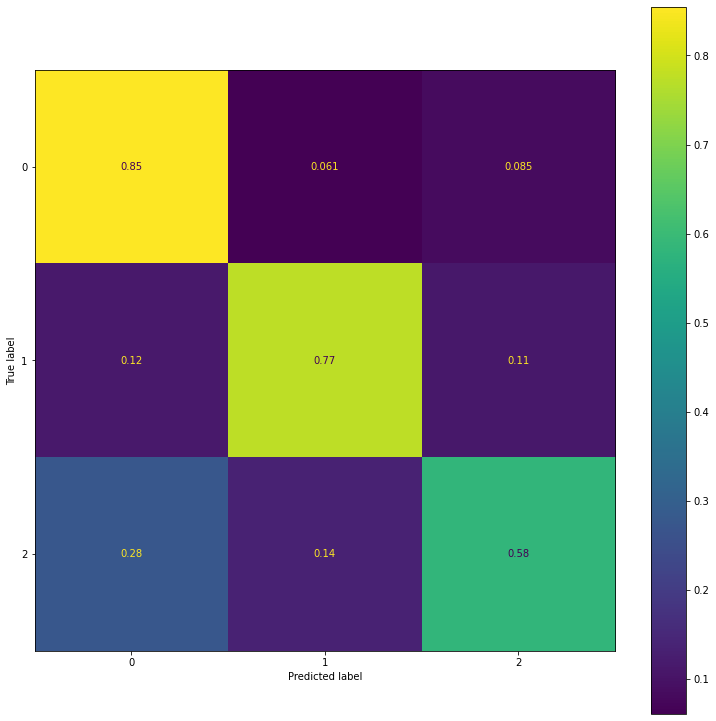

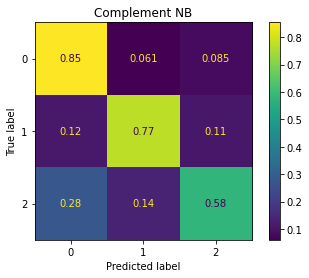

In [47]:
fig, ax = plt.subplots(figsize = (13, 13))
cm = ConfusionMatrixDisplay.from_estimator(model_CNB, x_test, y_test, normalize = "true") # %s instead of numbers
plt.title("Complement NB")
cm.plot(ax = ax)

# See how the biggest problem is again in class predicted 0 when it should be 2 and how class predicted 0 when it should be 1 is comparable to predicted 1 when it should be 1

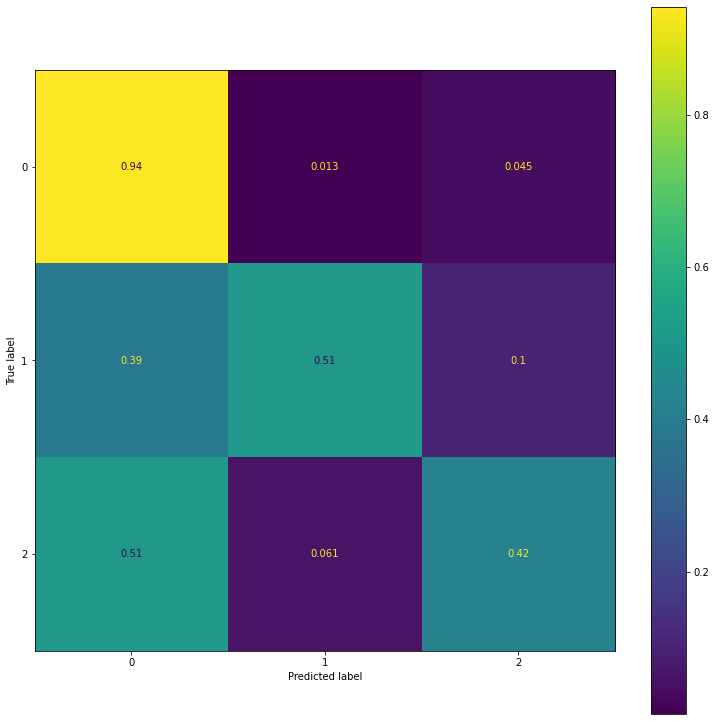

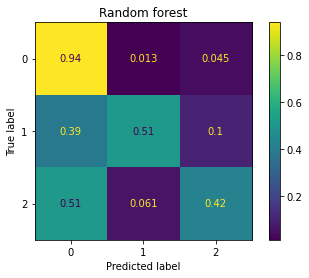

In [48]:
fig, ax = plt.subplots(figsize = (13, 13))
cm = ConfusionMatrixDisplay.from_estimator(model_RF, x_test, y_test, normalize = "true") # %s instead of numbers
plt.title("Random forest")
cm.plot(ax = ax)

# See how the biggest problem is the same as the logistic regression

## Now let's make a binary model to discriminate between positive and negative for simplicity of the interpretation